In [36]:
from obp.policy import Random, BernoulliTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from tqdm import tqdm

from dataset import ModifiedOpenBanditDataset
from estimator import InversePropensityScore as IPS
from util import (
    ActionEmbedOffPolicyEvaluation, 
    aggregate_simulation_results, 
    visualize_mean_squared_error
)

In [8]:
# settings

sample_sizes = [1000, 2000, 3000, 4000, 5000]

n_actions=80
len_list=3
sample_size=1000
random_state=12345
n_seeds=50
estimator_to_pscore_dict={"IPS": "action", "MIPS": "estimated_category"}

In [9]:
pi_ur = Random(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
)
pi_ts = BernoulliTS(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
    is_zozotown_prior=True,
    campaign="all",
)

# calc ground-truth policy value (on-policy)
policy_value = ModifiedOpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy="bts", campaign="all"
)

# define a dataset class
dataset = ModifiedOpenBanditDataset(
    behavior_policy="random",
    campaign="all",
)

result_df_list = []
for sample_size in sample_sizes:

    result_list = []
    for seed in tqdm(range(n_seeds), desc=f"sample_size={sample_size}..."):
        pi_b = pi_ur.compute_batch_action_dist(n_rounds=sample_size)
        pi_b = pi_b.reshape(sample_size, n_actions * len_list) / len_list

        pi_e = pi_ts.compute_batch_action_dist(n_rounds=sample_size)
        pi_e = pi_e.reshape(sample_size, n_actions * len_list) / len_list

        val_bandit_data = dataset.sample_bootstrap_bandit_feedback(
            sample_size=sample_size,
            random_state=seed
        )
        val_bandit_data["pscore"] = {
            "action": val_bandit_data["pscore"], 
            "pi": pi_b
        }
        evaluation_pscore_dict = {
            "action": pi_e[np.arange(sample_size), val_bandit_data["action"]].copy(), 
            "pi": pi_e
        }

        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_bandit_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            evaluation_policy_pscore=evaluation_pscore_dict
        )

        result_list.append(estimated_policy_values)

    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=sample_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
sample_size=1000...: 100% 50/50 [03:53<00:00,  4.67s/it]
sample_size=2000...: 100% 50/50 [04:18<00:00,  5.17s/it]
sample_size=3000...: 100% 50/50 [04:49<00:00,  5.79s/it]
sample_size=4000...: 100% 50/50 [05:27<00:00,  6.55s/it]
sample_size=5000...: 100% 50/50 [06:11<00:00,  7.43s/it]


In [5]:
result_df = pd.concat(result_df_list).reset_index(level=0)

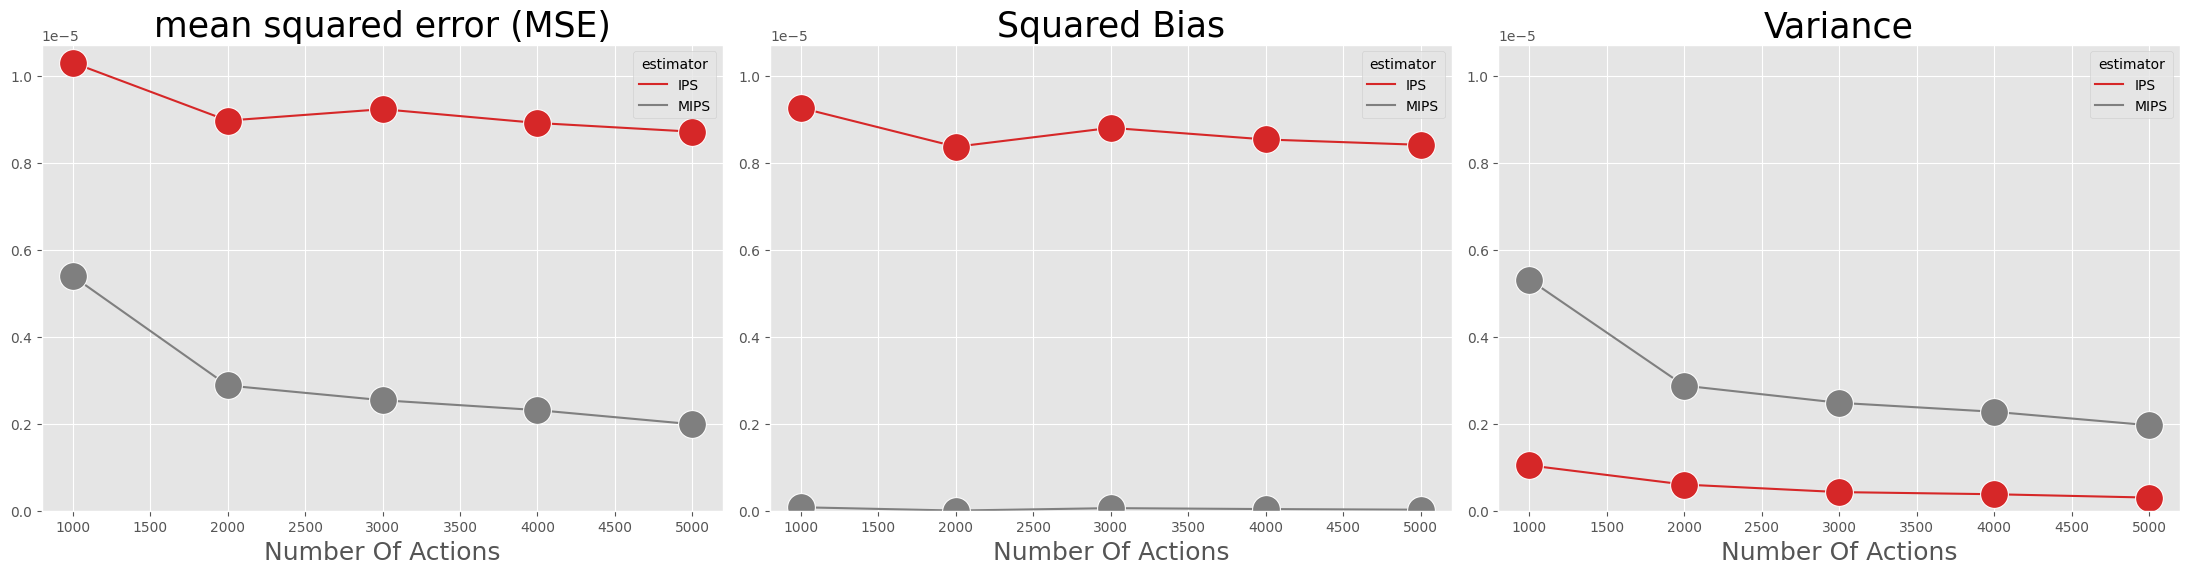

In [10]:
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Actions")

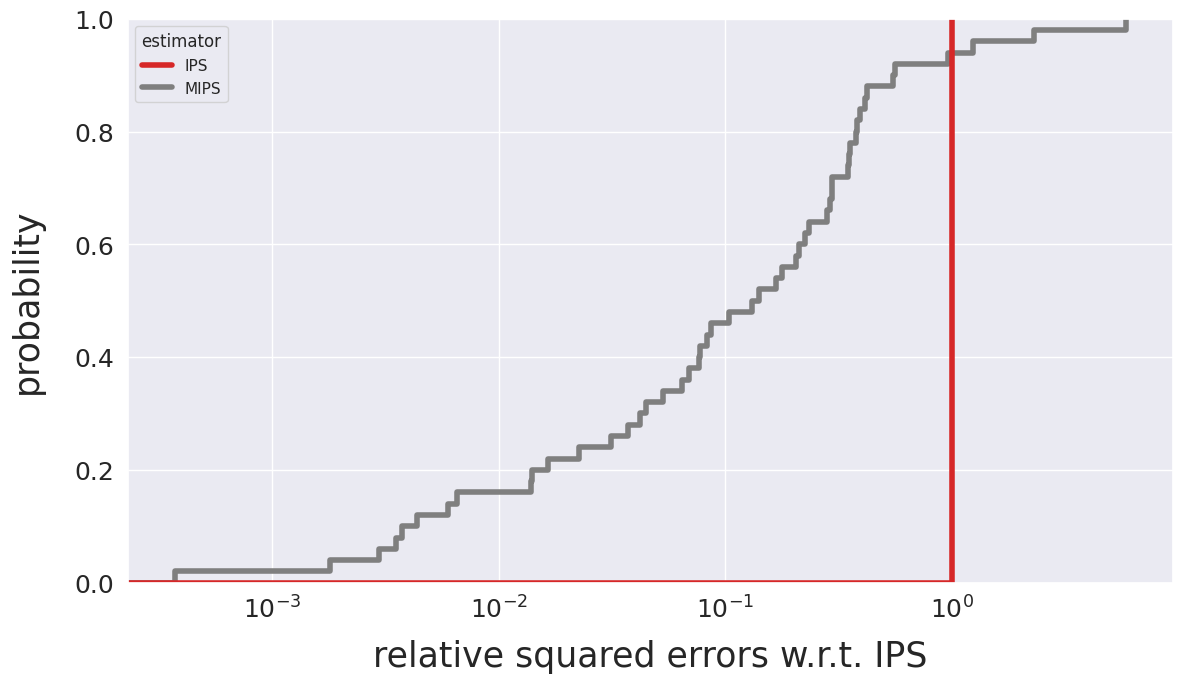

In [41]:
### CDF of relative SE ###

sample_size_mask = (result_df["x"] == 5000)

baselines = result_df[sample_size_mask & (result_df["estimator"] == "IPS")]["se"].values
mips_ses = result_df[sample_size_mask & (result_df["estimator"] == "MIPS")]["se"].values

rel_se_list = []
for baseline, mips_se in zip(baselines, mips_ses):
    rel_se_dict = dict()
    rel_se_dict["IPS"] = baseline / baseline
    rel_se_dict["MIPS"] = mips_se / baseline
    rel_se_list.append(rel_se_dict)

rel_result_df = (
    pd.DataFrame(pd.DataFrame(rel_se_list).stack())
    .reset_index(1)
    .rename(columns={"level_1": "estimator", 0: "se"})
)
rel_result_df.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots(figsize=(12, 7), tight_layout=True)
sns.ecdfplot(
    linewidth=4,
    palette={"IPS": "tab:red", "MIPS": "tab:gray"},
    data=rel_result_df,
    x="se",
    hue="estimator",
    ax=ax,
)

# yaxis
ax.set_ylabel("probability", fontsize=25)
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("relative squared errors w.r.t. IPS", fontsize=25)
ax.tick_params(axis="x", labelsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)